# Dataset analysis — GrooveGuru

This notebook analyses the parsed StepMania charts in `parsed_files/` and produces summary statistics and plots focused on `dance-single` charts.

What this notebook does:
- Collect all parsed chart filepaths (`sm_fp`) from `parsed_files/`
- Parse the `notes` sections of each `.sm` file to extract measure structure and difficulties
- Build a DataFrame with per-chart properties (type, difficulties, max pulses per measure, ...)
- Produce histograms and a simple analysis of how many charts would be lost if we limit maximum pulses per measure

Prerequisites:
1. The repository root is the workspace (this notebook uses absolute paths under `/home/lcros/GrooveGuru/parsed_files/`).
2. `parse.py` (and its helper functions) must be importable from the notebook.
3. Run cells top-to-bottom to populate `df` before viewing the plots.

In [1]:
# get all sm_fp from parsed_files
import os
import json

parsed_files = '/home/lcros/GrooveGuru/parsed_files/'
sm_fps = []
for file in os.listdir(parsed_files):
    if file.endswith('.json'):
        with open(os.path.join(parsed_files, file), 'r') as f:
            data = json.load(f)
            sm_fps.append(data['sm_fp'])

# `sm_fps` is now a list of absolute filepaths to the original .sm files (one per parsed JSON).

# Example (first few):

print(f"Found {len(sm_fps)} parsed JSON files. Example sm paths:\n", sm_fps[:5])

Found 29609 parsed JSON files. Example sm paths:
 ['/home/lcros/GrooveGuru/dataset/AI (CHUU SEISHIN)/AI (CHUU SEISHIN).sm', '/home/lcros/GrooveGuru/dataset/AKATSUKI NO KYOUSOUKYOKU/AKATSUKI NO KYOUSOUKYOKU.sm', '/home/lcros/GrooveGuru/dataset/ASTRAIA NO SOUBEI/ASTRAIA NO SOUBEI.sm', '/home/lcros/GrooveGuru/dataset/Bad Communication E.Style/Bad Communication E.Style.sm', '/home/lcros/GrooveGuru/dataset/BOKUSATSU TENSHI DOKURO-CHAN (RURUTIE-Mix)/BOKUSATSU TENSHI DOKURO-CHAN (RURUTIE-Mix).sm']


In [2]:
from parse import *
import re

### Notes parser

def notes_parser(x):
  pattern = r'([^:]*):' * 5 + r'([^;:]*)'
  notes_split = re.findall(pattern, x)
  if len(notes_split) != 1:
    raise ValueError('Bad formatting of notes section')
  notes_split = notes_split[0]
  if (len(notes_split) != 6):
    raise ValueError('Bad formatting within notes section')

  # parse/clean measures
  measures = [measure.splitlines() for measure in notes_split[5].split(',')]
  measures_clean = []
  for measure in measures:
    measure_clean = [pulse for pulse in measure if not pulse.strip().startswith('//') and len(pulse.strip()) > 0]
    measures_clean.append(measure_clean)
  if len(measures_clean) > 0 and len(measures_clean[-1]) == 0:
    measures_clean = measures_clean[:-1]

  # check measure lengths
  for measure in measures_clean:
    if len(measure) == 0:
      raise ValueError('Found measure with 0 notes')
    if not len(measure) in VALID_PULSES:
      parlog.warning('Nonstandard subdivision detected, allowing')

  return (str_parser(notes_split[0]),
    str_parser(notes_split[1]),
    str_parser(notes_split[2]),
    int_parser(notes_split[3]),
    list_parser(float_parser)(notes_split[4]),
    measures_clean
  )

def get_notes_data(sm_fp):
    with open(sm_fp, 'r') as sm_f:
        sm_txt = sm_f.read()
    
    all_notes_data = []
    for attr_name, attr_val in re.findall(r'#([^:]*):([^;]*);', sm_txt):
        attr_name = attr_name.lower()
        if attr_name == 'notes':
            notes_data = notes_parser(attr_val)
            all_notes_data.append(notes_data)
    return all_notes_data

In [3]:
import pandas as pd
import logging

# suppress logging warnings coming from notes_parser (e.g. "Nonstandard subdivision detected, allowing")
logging.disable(logging.WARNING)
try:
    all_data = []
    for sm_fp in sm_fps:
        notes_data = get_notes_data(sm_fp)
        for note_data in notes_data:
            try:
                all_data.append({
                    'sm_fp': sm_fp,
                    'type': note_data[0],
                    'difficulty_coarse': note_data[2],
                    'difficulty_fine': note_data[3],
                    'measures': note_data[5],
                    'max_pulses_in_measure': max(len(measure) for measure in note_data[5])
                })
            except Exception:
                # this probably means that note_data[5] is empty or malformed
                continue
finally:
    logging.disable(logging.NOTSET)

df = pd.DataFrame(all_data)
df.head()

,sm_fp,type,difficulty_coarse,difficulty_fine,measures,max_pulses_in_measure
0,/home/lcros/GrooveGuru/dataset/AI (CHUU SEISHI...,dance-single,Easy,3.0,"[[1001, 0000, 0001, 0000], [1000, 0000, 0001, ...",8
1,/home/lcros/GrooveGuru/dataset/AI (CHUU SEISHI...,dance-single,Hard,7.0,"[[0001, 0100, 0010, 1000, 1000, 0000, 0100, 00...",24
2,/home/lcros/GrooveGuru/dataset/AI (CHUU SEISHI...,dance-single,Challenge,9.0,"[[0001, 0000, 1000, 0010, 0000, 0010, 1000, 00...",48
3,/home/lcros/GrooveGuru/dataset/AI (CHUU SEISHI...,dance-single,Medium,6.0,"[[1001, 0100, 1100, 0000], [0010, 0010, 0100, ...",16
4,/home/lcros/GrooveGuru/dataset/AI (CHUU SEISHI...,dance-single,Beginner,1.0,"[[1000, 0000, 0000, 0000], [0001, 0000, 0000, ...",8


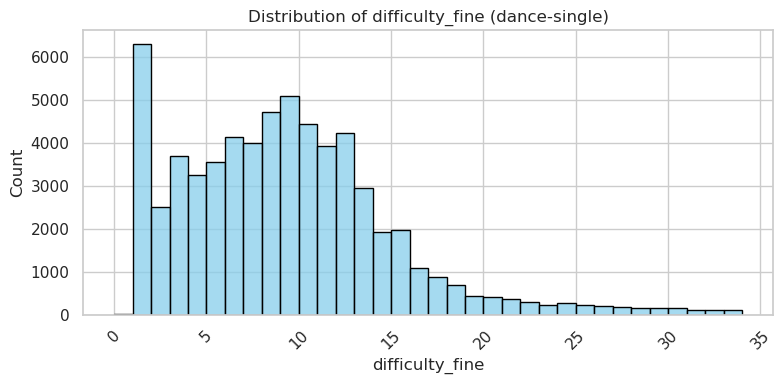

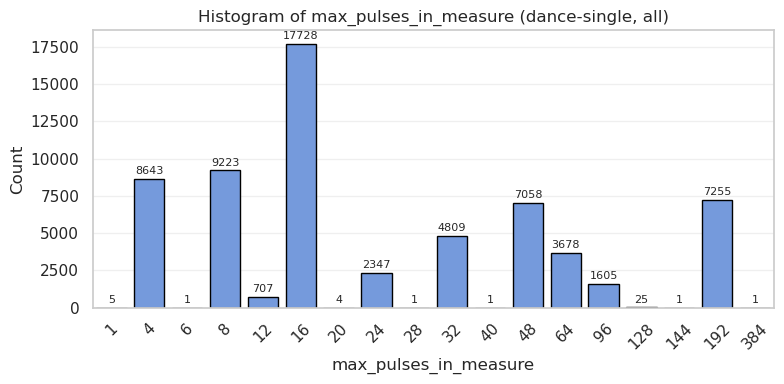

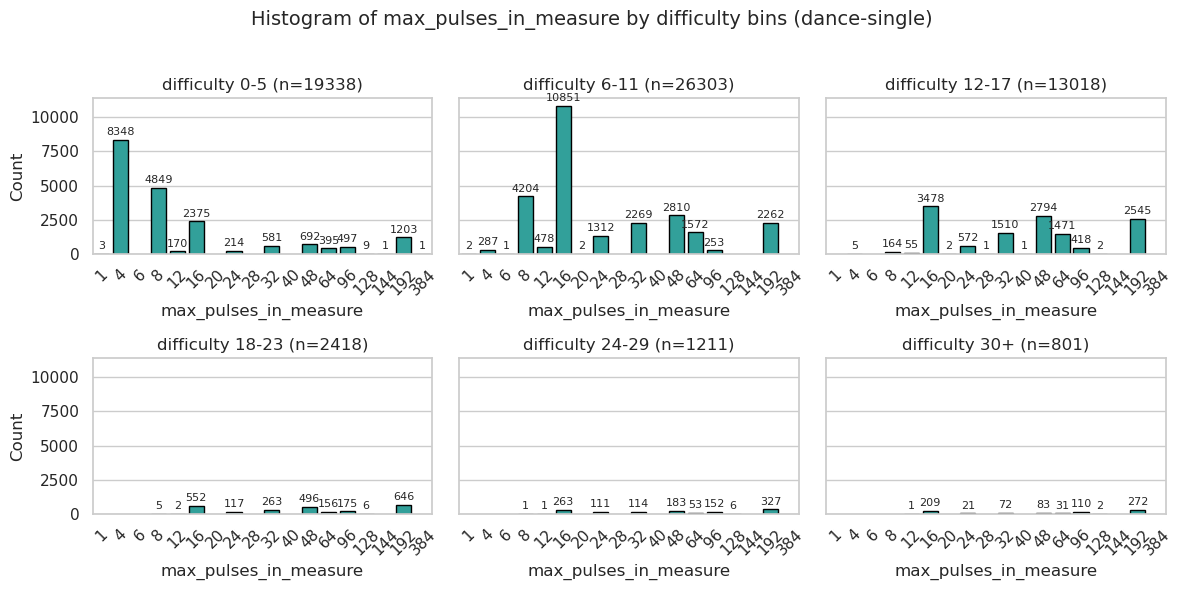

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# restrict to dance-single rows (use .copy() to avoid SettingWithCopyWarning)
df_dance = df[df['type'] == 'dance-single'].copy()

if df_dance.empty:
    print("No rows with type == 'dance-single'")
else:
    # ---- NEW: histogram of difficulty_fine ----
    plt.figure(figsize=(8, 4))
    sns.histplot(df_dance['difficulty_fine'], bins=range(0, 35, 1),
                 color="skyblue", edgecolor="black")
    plt.title('Distribution of difficulty_fine (dance-single)')
    plt.xlabel('difficulty_fine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ---- overall histogram of max_pulses_in_measure (categorical, ordered) ----
    plt.figure(figsize=(8, 4))

    # Ensure correct numeric order even though we treat x as strings
    x_order = sorted(df_dance['max_pulses_in_measure'].unique())
    x_order = [str(x) for x in x_order]

    sns.countplot(
        x=df_dance['max_pulses_in_measure'].astype(str),
        order=x_order,
        color='cornflowerblue',
        edgecolor='black'
    )

    plt.title('Histogram of max_pulses_in_measure (dance-single, all)')
    plt.xlabel('max_pulses_in_measure')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # annotate counts neatly
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=8, label_type='edge', padding=2)

    plt.tight_layout()
    plt.show()

    # ---- bin difficulty_fine ----
    bins = list(range(0, 31, 6)) + [df_dance['difficulty_fine'].max() + 1]
    labels = [f"{i}-{i+5}" for i in range(0, 30, 6)] + ["30+"]
    df_dance['difficulty_bin'] = pd.cut(df_dance['difficulty_fine'],
                                        bins=bins, labels=labels, right=False)

    # ---- histograms per difficulty bin (categorical x-axis, numeric order preserved) ----
    difficulties = df_dance['difficulty_bin'].unique().tolist()
    n = len(difficulties)
    cols = 3              
    rows = int(np.ceil(n / cols)) - 1

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, max(1, rows) * 3), sharey=True)
    axes = np.array(axes).flatten()

    # Get global x order (sorted unique values as strings)
    x_order = sorted(df_dance['max_pulses_in_measure'].unique())
    x_order = [str(x) for x in x_order]

    for ax, d in zip(axes, difficulties):
        subset = df_dance[df_dance['difficulty_bin'] == d]
        if subset.empty:
            continue

        # convert to string but maintain numeric order
        vals = subset['max_pulses_in_measure'].astype(str)

        sns.countplot(x=vals, order=x_order, ax=ax, color='lightseagreen', edgecolor='black')
        ax.set_title(f'difficulty {d} (n={len(vals)})')
        ax.set_xlabel('max_pulses_in_measure')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

        # annotate counts neatly above bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', fontsize=8, label_type='edge', padding=2)

    fig.suptitle('Histogram of max_pulses_in_measure by difficulty bins (dance-single)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



In [7]:
# how many charts would we lose if we only kept up to n pulses per measure?
max_pulses_limit = 32
print(f"Analysis of charts lost with max_pulses_in_measure limit of {max_pulses_limit}:")
num_charts_total = len(df_dance)
num_charts_within_limit = len(df_dance[df_dance['max_pulses_in_measure'] <= max_pulses_limit])
num_charts_lost = num_charts_total - num_charts_within_limit
percent_lost = (num_charts_lost / num_charts_total) * 100 if num_charts_total > 0 else 0
print(f"Total charts (dance-single): {num_charts_total}")
print(f"Charts with max_pulses_in_measure <= {max_pulses_limit}: {num_charts_within_limit}")
print(f"Charts lost if limit applied: {num_charts_lost} ({percent_lost:.2f}%)")

print("\nBreakdown by difficulty bin:")
# do the same for each difficulty bin
difficulty_bins = df_dance['difficulty_bin'].unique().tolist()
for d in difficulty_bins[:-1]:
    subset = df_dance[df_dance['difficulty_bin'] == d]
    total = len(subset)
    within_limit = len(subset[subset['max_pulses_in_measure'] <= max_pulses_limit])
    lost = total - within_limit
    percent = (lost / total) * 100 if total > 0 else 0
    print(f"Difficulty bin {d}: Total charts: {total}, Charts within limit: {within_limit}, Charts lost: {lost} ({percent:.2f}%)")


Analysis of charts lost with max_pulses_in_measure limit of 32:
Total charts (dance-single): 63092
Charts with max_pulses_in_measure <= 32: 43468
Charts lost if limit applied: 19624 (31.10%)

Breakdown by difficulty bin:
Difficulty bin 0-5: Total charts: 19338, Charts within limit: 16540, Charts lost: 2798 (14.47%)
Difficulty bin 6-11: Total charts: 26303, Charts within limit: 19406, Charts lost: 6897 (26.22%)
Difficulty bin 12-17: Total charts: 13018, Charts within limit: 5787, Charts lost: 7231 (55.55%)
Difficulty bin 18-23: Total charts: 2418, Charts within limit: 939, Charts lost: 1479 (61.17%)
Difficulty bin 24-29: Total charts: 1211, Charts within limit: 490, Charts lost: 721 (59.54%)
Difficulty bin 30+: Total charts: 801, Charts within limit: 303, Charts lost: 498 (62.17%)
